# Striplog with a binary 'flag'

We will invent a binary log -- maybe you can load it from an LAS file with `welly`.

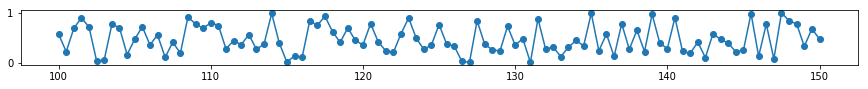

In [115]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

fake_depth = np.linspace(100, 150, 101)
fake_log = np.random.rand(fake_depth.size)

plt.figure(figsize=(15, 1))
plt.plot(fake_depth, fake_log, 'o-')

## Make a striplog

A `Striplog` is a sequence of `Interval` objects (representing a layer). Each `Interval` must contain a `Component` (representing the layer, perhaps a rock).

In [11]:
from striplog import Striplog, Component

In [133]:
comps = [
    Component({'pay': 'a'}),
    Component({'pay': 'b'}),
    Component({'pay': 'c'})
]

In [134]:
s = Striplog.from_log(fake_log, cutoff=[0.33, 0.66], components=comps, basis=fake_depth)

In [135]:
s[-1].base.middle = 150.5 # Adjust the bottom thickness... not sure if this is a bug.

Each `Interval` in the striplog looks like:

In [136]:
s[0]

Interval({'top': Position({'middle': 100.0, 'units': 'm'}), 'base': Position({'middle': 100.5, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'pay': 'b'})]})

## Plot the intervals

To plot we need a legend, but we can generate a random one. This maps each `Component` to a colour (and a width and hatch, if you want).

We can generate a random legend:

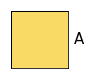

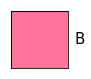

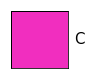

In [137]:
from striplog import Legend

legend = Legend.random(comps)
legend.get_decor(comps[-1]).width = 0.2
legend.plot()

Or we can make one with a bit more control:

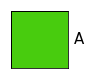

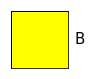

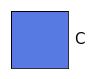

In [170]:

legend_csv = """colour,hatch,width,component pay
#48cc0e,None,1,a
#FFFF00,None,0.6,b
#5779e2,None,0.2,c"""

legend = Legend.from_csv(text=legend_csv)

legend.plot()

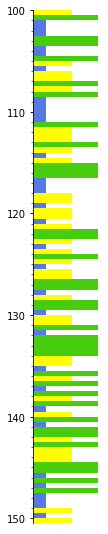

In [171]:
s.plot(legend=legend, aspect=5)

## Remove thin things

We can remove thin intervals:

In [140]:
pruned = s.prune(limit=1.0, keep_ends=True)

Now we can anneal the gaps:

In [141]:
annealed = pruned.anneal()

Then merge the adjacent intervals that are alike...

In [142]:
merged = annealed.merge_neighbours()  # Anneal works on a copy

We could have chained these commands:

    merged = s.prune(limit=1.0, keep_ends=True).anneal().merge_neighbours()

Let's plot all these steps, just for illustration:

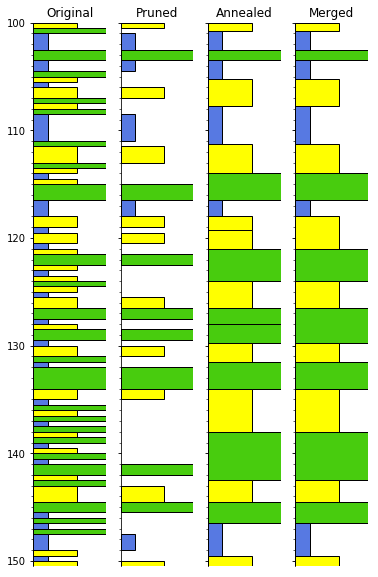

In [172]:
fig, axs = plt.subplots(ncols=4, figsize=(6, 10))

axs[0] = s.plot(legend=legend, ax=axs[0], lw=1, aspect=5)
axs[0].set_title('Original')
axs[1] = pruned.plot(legend=legend, ax=axs[1], lw=1, aspect=5)
axs[1].set_yticklabels([])
axs[1].set_title('Pruned')
axs[2] = annealed.plot(legend=legend, ax=axs[2], lw=1, aspect=5)
axs[2].set_yticklabels([])
axs[2].set_title('Annealed')
axs[3] = merged.plot(legend=legend, ax=axs[3], lw=1, aspect=5)
axs[3].set_yticklabels([])
axs[3].set_title('Merged')
plt.show()

## Dilate and erode

This would be a binary thing. Not implemented yet. I made an issue for this: https://github.com/agile-geoscience/striplog/issues/95

In [144]:
for iv in s:
    iv.data.update(iv.primary)

array([0, 0, 0, ..., 0, 0, 0])

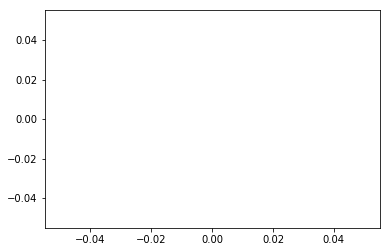

In [145]:
morphology.grey_erosion(l, structure=np.ones(20)).astype(int)

In [146]:
comps

[Component({'pay': 'a'}), Component({'pay': 'b'}), Component({'pay': 'c'})]

In [152]:
for iv in s:
    iv.data.update(iv.primary)
    
pay2int(s[0].data.get('pay'))

2

In [154]:
def pay2int(p):
    return ['c', 'b', 'a'].index(p) + 1

s.to_log(step=0.5, field='pay', table=['c', 'b', 'a'], return_meta=True)

(array([1., 2., 0., 0., 0., 2., 2., 0., 0., 2., 1., 0., 1., 1., 2., 1., 2.,
        0., 0., 0., 0., 0., 2., 1., 1., 1., 2., 1., 0., 1., 2., 2., 2., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 2., 2., 1., 0., 1., 2., 1., 0.,
        1., 1., 2., 2., 0., 1., 2., 2., 0., 1., 1., 2., 0., 2., 2., 2., 2.,
        1., 1., 0., 2., 1., 2., 0., 2., 1., 2., 0., 1., 2., 0., 2., 2., 1.,
        2., 1., 1., 1., 2., 2., 0., 2., 0., 2., 0., 0., 0., 1., 0., 1., 1.]),
 array([100. , 100.5, 101. , 101.5, 102. , 102.5, 103. , 103.5, 104. ,
        104.5, 105. , 105.5, 106. , 106.5, 107. , 107.5, 108. , 108.5,
        109. , 109.5, 110. , 110.5, 111. , 111.5, 112. , 112.5, 113. ,
        113.5, 114. , 114.5, 115. , 115.5, 116. , 116.5, 117. , 117.5,
        118. , 118.5, 119. , 119.5, 120. , 120.5, 121. , 121.5, 122. ,
        122.5, 123. , 123.5, 124. , 124.5, 125. , 125.5, 126. , 126.5,
        127. , 127.5, 128. , 128.5, 129. , 129.5, 130. , 130.5, 131. ,
        131.5, 132. , 132.5, 133. , 133.5, 13

In [167]:
from scipy.ndimage import morphology

def dilate(s, field, height=0.5, step=0.01, **kwargs):
    
    blog, basis, _ = s.to_log(step=step, field='pay', return_meta=True, **kwargs)
    
    blog = morphology.grey_dilation(blog + 1, structure=np.ones(int(height/step)))
    blog -= blog.min()
    
    return Striplog.from_log(blog / blog.max(), cutoff=[0.33, 0.66], components=comps[::-1], basis=basis)
    
    
def erode(s, field, height=0.5, step=0.01, **kwargs):
    
    blog, basis, _ = s.to_log(step=step, field='pay', return_meta=True, **kwargs)
    
    blog = morphology.grey_erosion(blog + 1, structure=np.ones(int(height/step)))
    blog -=blog.min()
    
    return Striplog.from_log(blog / blog.max(), cutoff=[0.33, 0.66], components=comps[::-1], basis=basis)

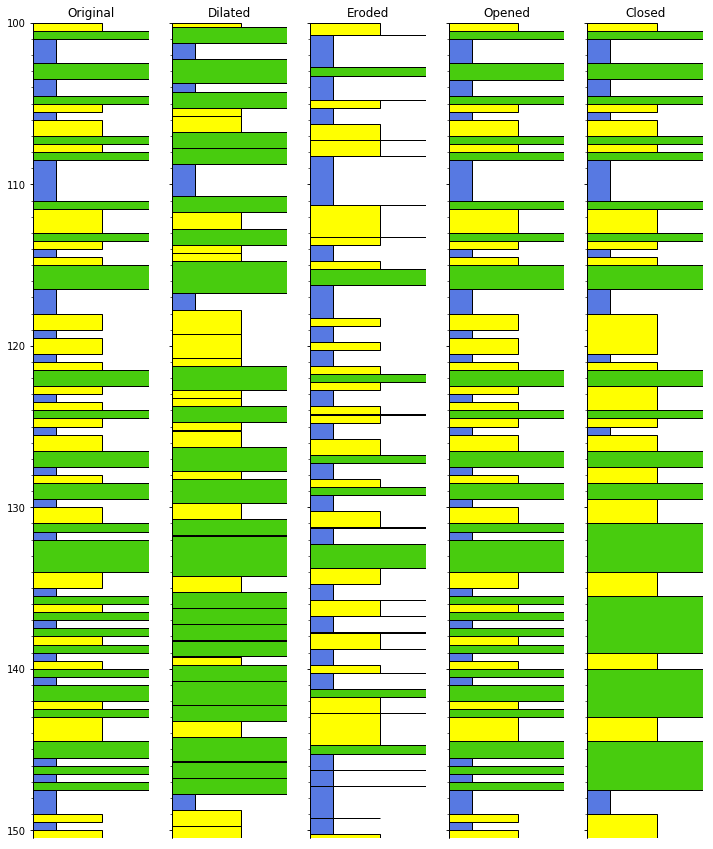

In [173]:
fig, axs = plt.subplots(ncols=5, figsize=(12, 15))

axs[0] = s.plot(legend=legend, ax=axs[0], lw=1, aspect=5)
axs[0].set_title('Original')

dilated = dilate(s, 'pay', table=['c', 'b', 'a'])
axs[1] = dilated.plot(legend=legend, ax=axs[1], lw=1, aspect=5)
axs[1].set_yticklabels([])
axs[1].set_title('Dilated')

eroded = erode(s, 'pay', table=['c', 'b', 'a'])
axs[2] = eroded.plot(legend=legend, ax=axs[2], lw=1, aspect=5)
axs[2].set_yticklabels([])
axs[2].set_title('Eroded')


for iv in eroded:
    iv.data.update(iv.primary)
    
opened = dilate(eroded, 'pay', table=['c', 'b', 'a'])
axs[3] = opened.plot(legend=legend, ax=axs[3], lw=1, aspect=5)
axs[3].set_yticklabels([])
axs[3].set_title('Opened')


for iv in dilated:
    iv.data.update(iv.primary)

closed = erode(dilated, 'pay', table=['c', 'b', 'a'])
axs[4] = closed.plot(legend=legend, ax=axs[4], lw=1, aspect=5)
axs[4].set_yticklabels([])
axs[4].set_title('Closed')
    
plt.show()

In [94]:
dilated[0]

Interval({'top': Position({'middle': 100.0, 'units': 'm'}), 'base': Position({'middle': 103.09, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'pay': False})]})

In [95]:
s[0]

Interval({'top': Position({'middle': 100.0, 'units': 'm'}), 'base': Position({'middle': 103.0, 'units': 'm'}), 'description': '', 'data': {'pay': True}, 'components': [Component({'pay': True})]})

## Some statistics

We can get the unique components and their thicknesses:

In [15]:
s.unique

[(Component({'pay': 'non-pay'}), 25.5), (Component({'pay': 'pay'}), 25.0)]

We can get at the thickest (and thinnest, with `.thinnest()`) intervals:

In [16]:
s.thickest()

Interval({'top': Position({'middle': 104.0, 'units': 'm'}), 'base': Position({'middle': 108.0, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'pay': 'pay'})]})

These functions optionally take an integer argument `n` specifying how many of the thickest or thinnest intervals you want to see. If `n` is greater than 1, a `Striplog` object is returned so you can see the positions of those items:

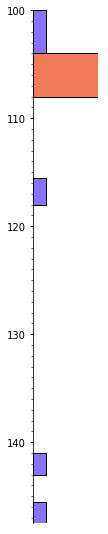

In [17]:
s.thickest(5).plot(legend=legend, lw=1, aspect=5)

## Bar plots and histograms

We can make a bar plot of the layers:

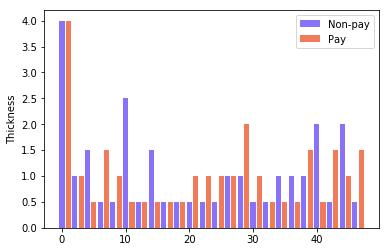

In [18]:
s.bar(legend=legend)

More interesting is to sort the thicknesses:

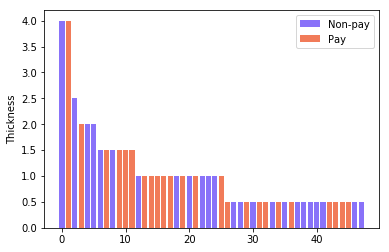

In [19]:
s.bar(legend=legend, sort=True)

Finally, we can make a thickness histogram of the various types of `component` present in the log.

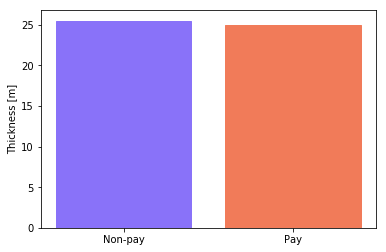

In [27]:
n, ents, ax = s.hist(legend=legend)

In [153]:
4 or 0

4